In [1]:
import os
from datasets import load_dataset
from PIL import Image
import pandas as pd
import torch

In [2]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [3]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)     # Show all rows
pd.set_option('display.max_colwidth', None) # Show full content of each column (no truncation)
pd.set_option('display.width', None)

In [4]:
dataset = load_dataset("ahmedheakl/arocrbench_patsocr",split="train")

In [5]:
dataset

Dataset({
    features: ['image', 'answer', 'source'],
    num_rows: 500
})

In [6]:
results = []
for sample in dataset:
    image = sample["image"]  # Already a PIL Image object
    if image.mode != "RGB":
        image = image.convert("RGB")
    ground_truth = sample["answer"]
    results.append({
        "image": image,
        "ground_truth": ground_truth,
        "qwenv2.5_3B": None,
        
    })
print(f"Initialized results with {len(results)} samples.")

Initialized results with 500 samples.


## Qwenvl2.5 3B 

In [7]:
import torch 
torch.cuda.empty_cache()

In [8]:
from transformers import AutoProcessor, AutoModelForImageTextToText

processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-3B-Instruct",use_fast=True)

model = AutoModelForImageTextToText.from_pretrained("Qwen/Qwen2.5-VL-3B-Instruct",torch_dtype="auto",device_map="cuda:0")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
from PIL import Image 
import requests

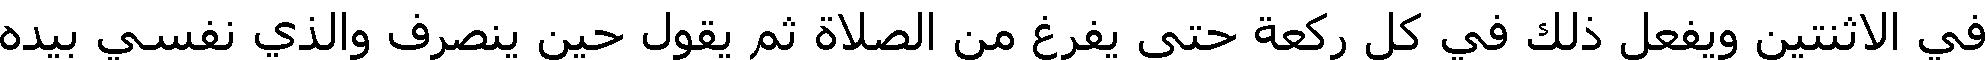

In [10]:
image = dataset[2]['image']
image

In [12]:
dataset[2]['answer']

'في الاثنتين ويفعل ذلك في كل ركعة حتى يفرغ من الصلاة ثم يقول حين ينصرف والذي نفسي بيده\n'

In [13]:
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
            },
            {
                "type": "text",
                "text": "extract the arabic text in the following image"
            }
        ]
    }
]

text_prompt = processor.apply_chat_template(messages, add_generation_prompt=True)



In [14]:
def qwen_extract_ocr(text_prompt,image):
    
    inputs = processor(
        text = [text_prompt],
        images = [image],
        padding = True,
        return_tensors = "pt"
    )

    inputs = inputs.to("cuda")

    output_ids = model.generate(**inputs, max_new_tokens=1024)

    generated_ids = [
        output_ids[len(input_ids) :]
        for input_ids, output_ids in zip(inputs.input_ids, output_ids)
    ]

    output_text = processor.batch_decode(
        generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
    )
    return output_text


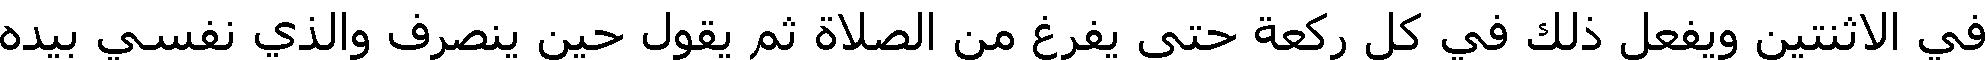

In [15]:
image = dataset[2]['image']
image

In [16]:
qwen_extract_ocr(text_prompt,image=dataset[2]['image'])


['في الاتنين ويفعل ذلك في كل ركعة حتى يفرغ من الصلاة ثم يقول حين ينصرف والذي نفسي بيده']

In [17]:

for i, sample in enumerate(results):
    torch.cuda.empty_cache()
    image = sample['image'].resize((512,512))
    text_result = " ".join(qwen_extract_ocr(text_prompt,image=image)).replace("The Arabic text in the image is:\n\n","")
    print(text_result)
    print("*****"*40)
    results[i]['qwenv2.5_3B'] = text_result

"العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية العربية

In [26]:
import re

def remove_diacritics(text):
    diacritics = [
        '\u0617', '\u0618', '\u0619', '\u061A',  # Small high signs
        '\u064B', '\u064C', '\u064D', '\u064E', '\u064F', '\u0650',  # Tanween and basic diacritics
        '\u0651', '\u0652', '\u0653', '\u0654', '\u0655', '\u0656',  # Shadda, sukun, etc.
        '\u0657', '\u0658', '\u0659', '\u065A', '\u065B', '\u065C', 
        '\u065D', '\u065E', '\u065F', '\u0670'   # Additional Arabic diacritics
    ]
    pattern = '[' + ''.join(diacritics) + ']'
    return re.sub(pattern, '', text)
def remove_english_letters(text):
    # Regex pattern to match English letters (a-z and A-Z)
    pattern = r'[a-zA-Z]'
    # Replace English letters with an empty string
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text

In [27]:
df = pd.DataFrame(results)
df.head()

image  \
0   <PIL.Image.Image image mode=RGB size=1464x77 at 0x7B4090188250>   
1   <PIL.Image.Image image mode=RGB size=1187x75 at 0x7B40901EB290>   
2   <PIL.Image.Image image mode=RGB size=1985x60 at 0x7B40901F3B10>   
3  <PIL.Image.Image image mode=RGB size=1242x105 at 0x7B409ACCE2D0>   
4   <PIL.Image.Image image mode=RGB size=1552x57 at 0x7B4090193650>   

                                                                                  ground_truth  \
0     فلان ثم فلان يسميهم أبو رجاء فنسي عوف ثم عمر بن الخطاب الرابع وكان النبي صلى الله عليه\n   
1        معي صبرا قال لا تؤاخذني بما نسيت فكانت الأولى من موسى نسيانا فانطلقا فإذا غلام يلعب\n   
2      في الاثنتين ويفعل ذلك في كل ركعة حتى يفرغ من الصلاة ثم يقول حين ينصرف والذي نفسي بيده\n   
3       صلى الله عليه وسلم خرج حين زاغت الشمس فصلى الظهر فقام على المنبر فذكر الساعة فذكر أن\n   
4  ليتني فيها جذع ليتني أكون حيا إذ يخرجك قومك فقال رسول الله صلى الله عليه وسلم أو مخرجي هم\n   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [28]:
df['ground_truth'] = df['ground_truth'].apply(remove_english_letters)
df['qwenv2.5_3B'] = df['qwenv2.5_3B'].apply(remove_english_letters)

In [29]:

df['ground_truth_t'] = df["ground_truth"].apply(remove_diacritics)
df['qwenv2.5_3B_t'] = df["qwenv2.5_3B"].apply(remove_diacritics)


In [30]:
df.head()

image  \
0   <PIL.Image.Image image mode=RGB size=1464x77 at 0x7B4090188250>   
1   <PIL.Image.Image image mode=RGB size=1187x75 at 0x7B40901EB290>   
2   <PIL.Image.Image image mode=RGB size=1985x60 at 0x7B40901F3B10>   
3  <PIL.Image.Image image mode=RGB size=1242x105 at 0x7B409ACCE2D0>   
4   <PIL.Image.Image image mode=RGB size=1552x57 at 0x7B4090193650>   

                                                                                  ground_truth  \
0     فلان ثم فلان يسميهم أبو رجاء فنسي عوف ثم عمر بن الخطاب الرابع وكان النبي صلى الله عليه\n   
1        معي صبرا قال لا تؤاخذني بما نسيت فكانت الأولى من موسى نسيانا فانطلقا فإذا غلام يلعب\n   
2      في الاثنتين ويفعل ذلك في كل ركعة حتى يفرغ من الصلاة ثم يقول حين ينصرف والذي نفسي بيده\n   
3       صلى الله عليه وسلم خرج حين زاغت الشمس فصلى الظهر فقام على المنبر فذكر الساعة فذكر أن\n   
4  ليتني فيها جذع ليتني أكون حيا إذ يخرجك قومك فقال رسول الله صلى الله عليه وسلم أو مخرجي هم\n   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [31]:
from jiwer import wer, cer 

# for model in ["tesseract","easyocr"]:
for model in ["qwenv2.5_3B"]:
    wer_score = wer(df["ground_truth"].tolist(), df[model].tolist())
    cer_score = cer(df["ground_truth"].tolist(), df[model].tolist())
    print(f"{model} - WER: {wer_score:.2f}, CER: {cer_score:.2f}")

qwenv2.5_3B - WER: 3.50, CER: 4.13


In [32]:
from jiwer import wer, cer 

# for model in ["tesseract","easyocr"]:
for model in ["qwenv2.5_3B_t"]:
    wer_score = wer(df["ground_truth_t"].tolist(), df[model].tolist())
    cer_score = cer(df["ground_truth_t"].tolist(), df[model].tolist())
    print(f"{model} - WER: {wer_score:.2f}, CER: {cer_score:.2f}")

qwenv2.5_3B_t - WER: 3.48, CER: 3.86


In [33]:
df.to_csv("khattat_dl_pastocr_result.csv")